In [1]:
import os
import glob
import re
import datetime
import glob
from datetime import date, time, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, product
from cv2 import VideoCapture, CAP_PROP_FRAME_COUNT, CAP_PROP_FPS, CAP_PROP_POS_FRAMES
import ffmpeg
from imutils.video import FileVideoStream
import time
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Span, DatetimeTicker, DatetimeTickFormatter
from scipy import stats
from utils import load_diffs, load_slide_changes, load_intervals
from utils import filter_video, plot_slide_diffs, get_signals, get_hmm_signals, get_kf_signals, evaluate
from hmmlearn import hmm
from tsmoothie.smoother import *

sns.set()
output_notebook()

Loading BokehJS ...

# Generate Results

In [2]:
meetings = [160320, 220120, 170127, 83512718053]
masks = [True, False]

In [3]:
scores = []
hmm_scores = []
kf_scores = []
for masked, meeting_id in product(masks, meetings):
    print(f'Evaluating experiment meeting_id={meeting_id} and masked={masked}')
    video_path = glob.glob(f'zoom_data/{meeting_id}/*.mp4')[0]
    if masked:
        diff_path = f'diff_data/diffs_{meeting_id}_pct_masked_cossim.csv'
    else:
        diff_path = f'diff_data/diffs_{meeting_id}_cossim.csv'
    sc_labels = f'slide_change_labels/{meeting_id}.csv'
    interval_path = 'interval_data/intervals.csv'
    
    vidcap = VideoCapture(video_path)
    fps = vidcap.get(CAP_PROP_FPS)
    ddiffs = load_diffs(diff_path, fps)
    sldf = load_slide_changes(sc_labels)
    idf = load_intervals(interval_path, meeting_id=meeting_id)
    ddiffs = filter_video(ddiffs, idf)
    
    ## Percentile
    _, mean_q = get_signals(ddiffs)
    percentiles = np.arange(mean_q / 100 - 0.1, 1.0, 0.001)
    exp_keys = {'meeting_id': meeting_id, 'masked': masked}
    for q in percentiles:
        #print(f'\tScoring q = {q}')
        signals, _ = get_signals(ddiffs, threshold_q=q)
        results = evaluate(ddiffs, sldf, signals)
        rec = []
        for score in ['accuracy', 'precision', 'recall', 'f1']:
            rec.append({**exp_keys, 'mean_q': mean_q, 'threshold': q, 'score': score, 'value': results[score]})
        scores.extend(rec)
        
    ## HMM
    hmm_model = hmm.GaussianHMM(n_components=2)
    signals = get_hmm_signals(ddiffs, hmm_model)
    results = evaluate(ddiffs, sldf, signals)
    rec = []
    for score in ['accuracy', 'precision', 'recall', 'f1']:
        rec.append({**exp_keys, 'score': score, 'value': results[score]})
    hmm_scores.extend(rec) 
    
    ## Kalman Filter
    smoother = KalmanSmoother(component='level', component_noise={'level': 0.5})
    signals = get_kf_signals(ddiffs, smoother)
    results = evaluate(ddiffs, sldf, signals)
    rec = []
    for score in ['accuracy', 'precision', 'recall', 'f1']:
        rec.append({**exp_keys, 'score': score, 'value': results[score]})
    kf_scores.extend(rec)
sdf = pd.DataFrame(scores)
hmm_sdf = pd.DataFrame(hmm_scores)
kf_sdf = pd.DataFrame(kf_scores)

Evaluating experiment meeting_id=160320 and masked=True
Evaluating experiment meeting_id=220120 and masked=True
Evaluating experiment meeting_id=170127 and masked=True
Evaluating experiment meeting_id=83512718053 and masked=True
Evaluating experiment meeting_id=160320 and masked=False
Evaluating experiment meeting_id=220120 and masked=False
Evaluating experiment meeting_id=170127 and masked=False
Evaluating experiment meeting_id=83512718053 and masked=False


# Visualize

### Scores
---
Some of the recalls don't go to 100% - this is likely due to some slide changes not getting a signal for whatever reason.

For example, for meeting_id=160320, there are two quick slide changes in consecutive seconds (07:24-07:25).  The signal must have gotten lost in the discretizing procedure.  This is something to ask Christof about - should we make a rule for very fast slide changes (ie, count them all as one)?  Doing so will likely improve the scores.

Also, how can I generalize the optimal threshold?  Right now, these values seem pretty sensitive.  How to quantify the sensitivity?  I won't always have annotations, so determining this will be important.

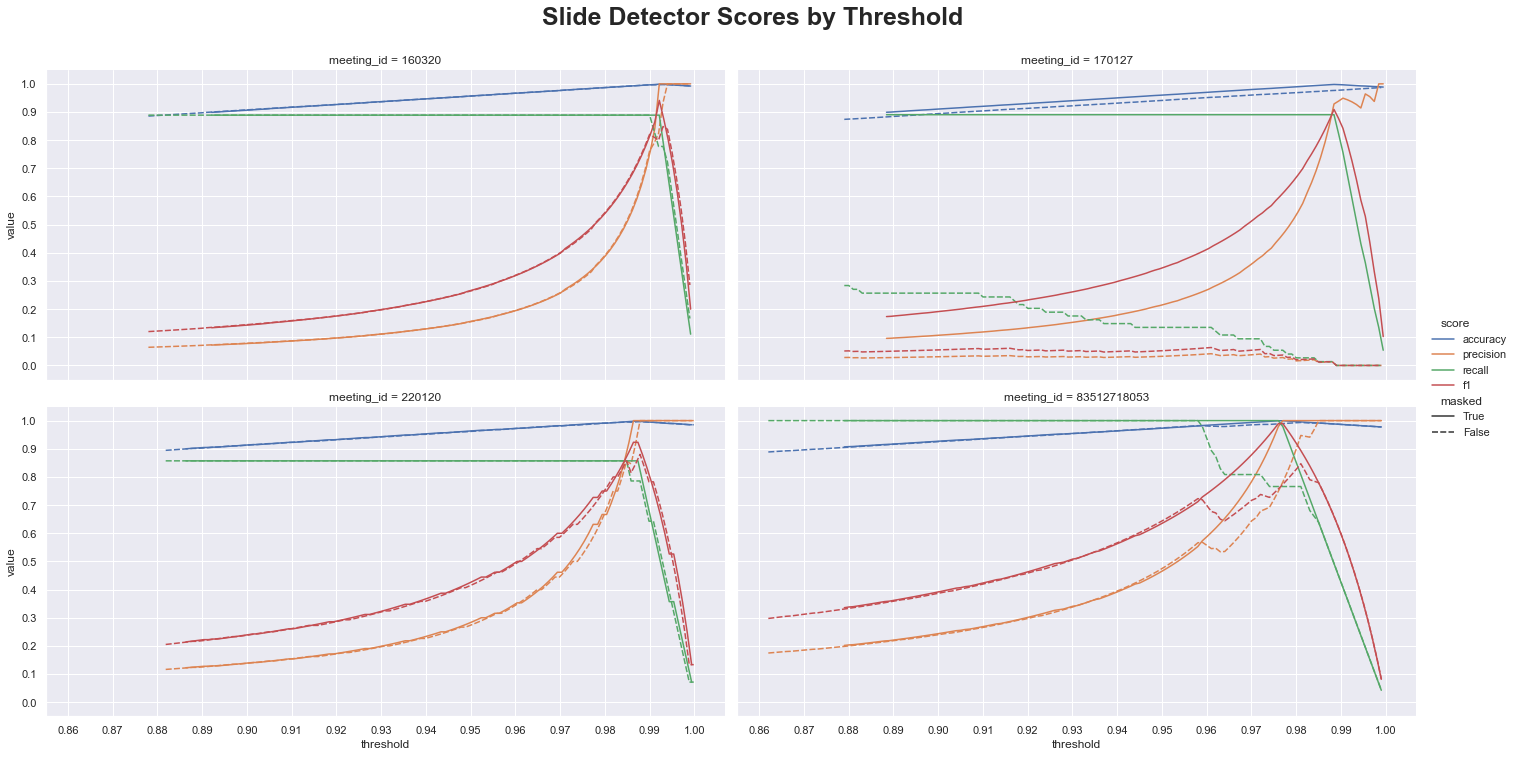

In [4]:
g = sns.relplot(x='threshold', y='value', hue='score', col='meeting_id', style='masked', 
                style_order=[True, False], data=sdf, col_wrap=2, kind='line', 
                aspect=2)
g.set(xticks=np.arange(0.86, 1.0, 0.01), yticks=np.arange(0, 1.1, 0.1))
g.fig.suptitle('Slide Detector Scores by Threshold', y=1.05, fontsize=25, fontweight='bold');
#plt.axvline(mean_q / 100, c='k', linestyle='dashed', linewidth=1);

### F1 scores only

In [5]:
sdf

,meeting_id,masked,mean_q,threshold,score,value
0,160320,True,99.218368,0.892184,accuracy,0.898876
1,160320,True,99.218368,0.892184,precision,0.072398
2,160320,True,99.218368,0.892184,recall,0.888889
3,160320,True,99.218368,0.892184,f1,0.133891
4,160320,True,99.218368,0.893184,accuracy,0.899853
...,...,...,...,...,...,...
3815,83512718053,False,96.203796,0.998038,f1,0.156863
3816,83512718053,False,96.203796,0.999038,accuracy,0.977522
3817,83512718053,False,96.203796,0.999038,precision,1.000000
3818,83512718053,False,96.203796,0.999038,recall,0.042553


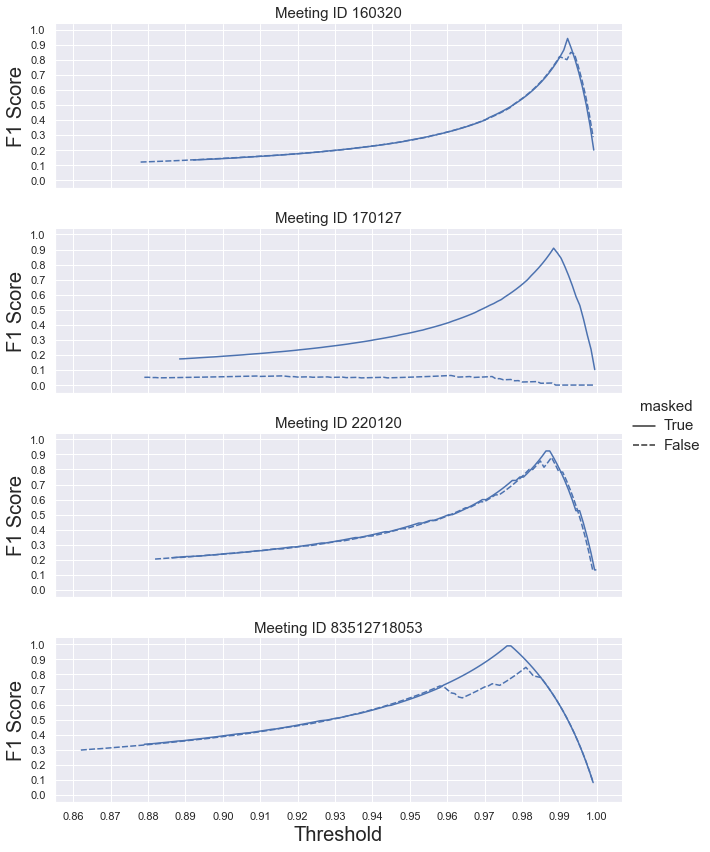

In [10]:
g = sns.relplot(x='threshold', y='value', row='meeting_id', style='masked', 
                style_order=[True, False], data=sdf.query("score == 'f1'"), kind='line', 
                height=3, aspect=3)
g.set(xticks=np.arange(0.86, 1.0, 0.01), yticks=np.arange(0, 1.1, 0.1))
#g.fig.suptitle('Slide Detector Scores by Threshold', y=1.05, fontsize=25, fontweight='bold')
g.set_titles(row_template='Meeting ID {row_name}', size=15)
g.set_xlabels("Threshold", size=20)
for ax in g.axes.flat:
    ax.set_ylabel("F1 Score", size=20)
    #ax.tick_params(axis='x', rotation=90)
g.legend.get_title().set_fontsize(15)
for t in g.legend.get_texts():
    t.set_fontsize(15)
g.tight_layout(h_pad=2)
plt.savefig("thesis/mscs_thesis/figures/3_2_2_f1bythresh.pdf", dpi=300, bbox_inches='tight')
#plt.axvline(mean_q / 100, c='k', linestyle='dashed', linewidth=1);

### Max F1 Comparison

In [4]:
max_f1s = sdf.query("score == 'f1'").groupby(['meeting_id', 'masked', 'score'], as_index=False).value.max()
#max_f1s

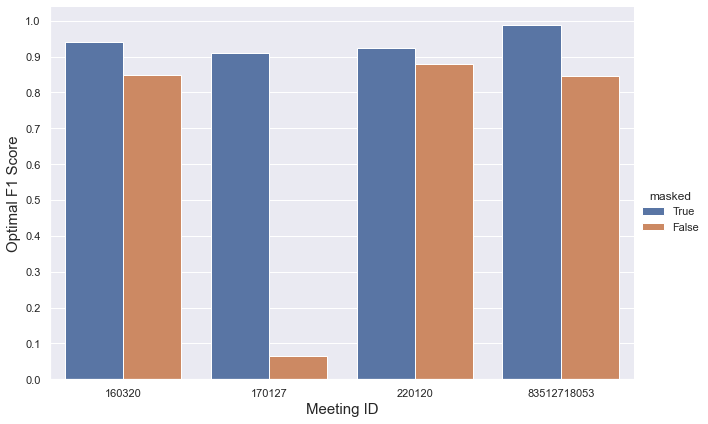

In [9]:
g = sns.catplot(x='meeting_id', y='value', hue='masked', data=max_f1s, kind='bar', height=6, aspect=1.5, hue_order=[True, False])
g.set(yticks=np.arange(0, 1.1, 0.1))
for ax in g.axes.flat:
    ax.set_ylabel("Optimal F1 Score", size=15)
    ax.set_xlabel("Meeting ID", size=15)
plt.savefig("thesis/mscs_thesis/figures/3_2_2_maxf1pct.pdf", dpi=300, bbox_inches='tight')
#g.fig.suptitle('Max F1 Score by Meeting', y=1.05, fontsize=20);

In [5]:
qs = sdf.merge(max_f1s, on=['meeting_id', 'masked', 'score', 'value']) \
       .groupby(['meeting_id', 'masked', 'score', 'value'], as_index=False) \
       .threshold \
       .min()

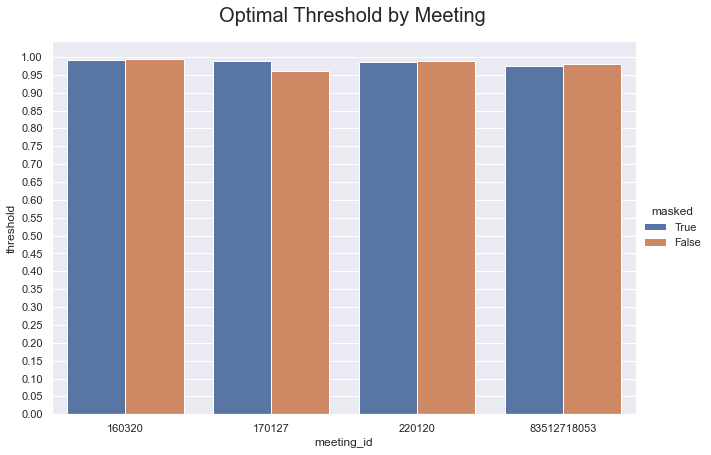

In [7]:
g = sns.catplot(x='meeting_id', y='threshold', hue='masked', data=qs, kind='bar', height=6, aspect=1.5, hue_order=[True, False])
g.set(yticks=np.arange(0, 1.05, 0.05))
g.fig.suptitle('Optimal Threshold by Meeting', y=1.05, fontsize=20);

In [25]:
#qs

,meeting_id,masked,score,value,threshold
0,160320,False,f1,0.848485,0.993017
1,160320,True,f1,0.941176,0.992184
2,170127,False,f1,0.063694,0.961014
3,170127,True,f1,0.909091,0.988450
4,220120,False,f1,0.880000,0.987880
5,220120,True,f1,0.923077,0.986410
6,83512718053,False,f1,0.847059,0.981038
7,83512718053,True,f1,0.989474,0.976021


In [28]:
#qs[['meeting_id', 'masked', 'threshold']].pivot(index='meeting_id', columns='masked', values='threshold')

0.9760209790209792

# HMM Comparison

### Masked

In [5]:
pct_f1s = sdf.query("score == 'f1' and masked").groupby(['meeting_id'], as_index=False).value.max()
pct_f1s['model'] = 'percentile'
hmm_f1s = hmm_sdf.query("score == 'f1' and masked").reset_index(drop=True).drop(columns=['masked', 'score'])
hmm_f1s['model'] = 'hmm'
f1s = pd.concat([pct_f1s, hmm_f1s])

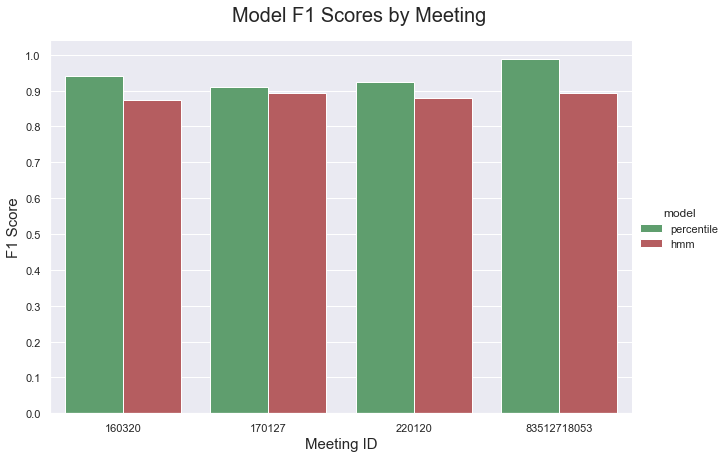

In [66]:
g = sns.catplot(x='meeting_id', y='value', hue='model', data=f1s, kind='bar', height=6, aspect=1.5,palette=sns.color_palette()[2:4])
g.set(yticks=np.arange(0, 1.1, 0.1))
for ax in g.axes.flat:
    ax.set_xlabel("Meeting ID", size=15)
    ax.set_ylabel("F1 Score", size=15)
g.fig.suptitle('Model F1 Scores by Meeting', y=1.05, fontsize=20);

In [17]:
#f1s

In [6]:
f1s_pivoted = f1s.pivot(index='meeting_id', columns='model', values='value')
f1s_pivoted['diff'] = f1s_pivoted.hmm - f1s_pivoted.percentile
f1s_pivoted

model,hmm,percentile,diff
meeting_id,,,
160320,0.875000,0.941176,-0.066176
170127,0.892086,0.909091,-0.017005
220120,0.880000,0.923077,-0.043077
83512718053,0.894118,0.989474,-0.095356


### Unmasked

In [7]:
pct_f1s = sdf.query("score == 'f1' and not masked").groupby(['meeting_id'], as_index=False).value.max()
pct_f1s['model'] = 'percentile'
hmm_f1s = hmm_sdf.query("score == 'f1' and not masked").reset_index(drop=True).drop(columns=['masked', 'score'])
hmm_f1s['model'] = 'hmm'
f1s = pd.concat([pct_f1s, hmm_f1s])

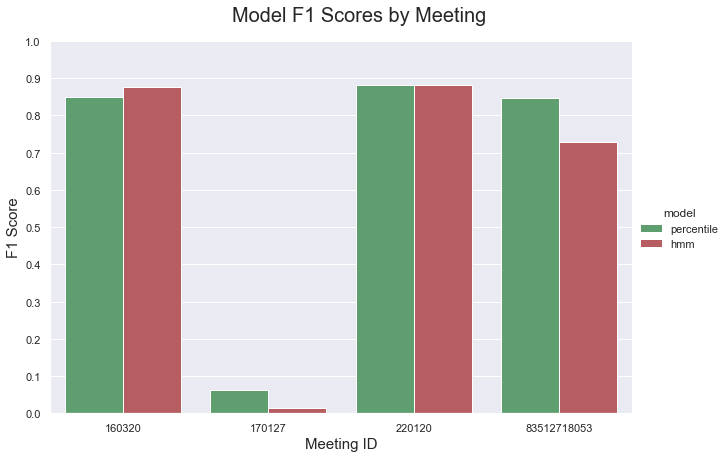

In [64]:
g = sns.catplot(x='meeting_id', y='value', hue='model', data=f1s, kind='bar', height=6, aspect=1.5,palette=sns.color_palette()[2:4])
g.set(yticks=np.arange(0, 1.1, 0.1))
for ax in g.axes.flat:
    ax.set_xlabel("Meeting ID", size=15)
    ax.set_ylabel("F1 Score", size=15)
g.fig.suptitle('Model F1 Scores by Meeting', y=1.05, fontsize=20);

# KF Comparison

### Masked

In [19]:
pct_f1s = sdf.query("score == 'f1' and masked").groupby(['meeting_id'], as_index=False).value.max()
pct_f1s['model'] = 'percentile'
hmm_f1s = hmm_sdf.query("score == 'f1' and masked").reset_index(drop=True).drop(columns=['masked', 'score'])
hmm_f1s['model'] = 'hmm'
kf_f1s = kf_sdf.query("score == 'f1' and masked").reset_index(drop=True).drop(columns=['masked', 'score'])
kf_f1s['model'] = 'kalman'
f1s = pd.concat([pct_f1s, hmm_f1s, kf_f1s])

In [20]:
f1s

,meeting_id,value,model
0,160320,0.941176,percentile
1,170127,0.909091,percentile
2,220120,0.923077,percentile
3,83512718053,0.989474,percentile
0,160320,0.875000,hmm
1,220120,0.880000,hmm
2,170127,0.892086,hmm
3,83512718053,0.894118,hmm
0,160320,0.941176,kalman
1,220120,0.923077,kalman


In [21]:
f1sp = f1s.pivot(index='meeting_id', columns='model')
f1sp.columns = [col for _, col in f1sp.columns]
f1sp

,hmm,kalman,percentile
meeting_id,,,
160320,0.875000,0.941176,0.941176
170127,0.892086,0.900000,0.909091
220120,0.880000,0.923077,0.923077
83512718053,0.894118,0.978261,0.989474


In [23]:
f1sp.columns

Index(['hmm', 'kalman', 'percentile'], dtype='object')

In [22]:
f1sp.columns = [col for _, col in f1sp.columns]

ValueError: too many values to unpack (expected 2)

In [24]:
(f1sp.kalman - f1sp.percentile).abs().mean()

0.005075930934054507

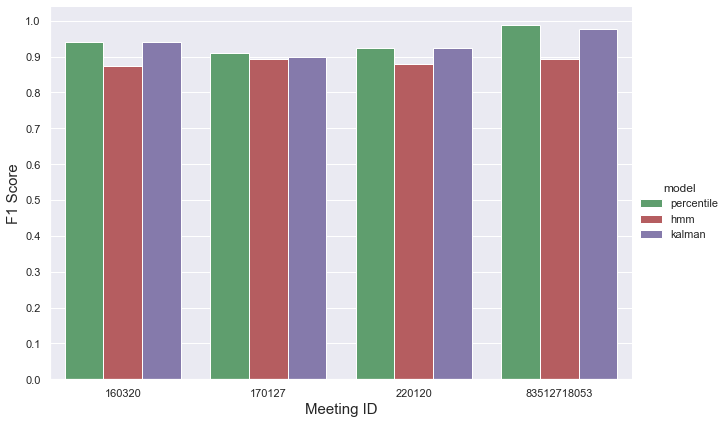

In [25]:
g = sns.catplot(x='meeting_id', y='value', hue='model', data=f1s, kind='bar', height=6, aspect=1.5,palette=sns.color_palette()[2:5])
g.set(yticks=np.arange(0, 1.1, 0.1))
for ax in g.axes.flat:
    ax.set_xlabel("Meeting ID", size=15)
    ax.set_ylabel("F1 Score", size=15)
plt.savefig("thesis/mscs_thesis/figures/3_2_5_pctvskfvshmmf1_masked.pdf", dpi=300, bbox_inches='tight')
#g.fig.suptitle('Model F1 Scores by Meeting', y=1.05, fontsize=20);

### Unmasked

In [26]:
pct_f1s = sdf.query("score == 'f1' and not masked").groupby(['meeting_id'], as_index=False).value.max()
pct_f1s['model'] = 'percentile'
hmm_f1s = hmm_sdf.query("score == 'f1' and not masked").reset_index(drop=True).drop(columns=['masked', 'score'])
hmm_f1s['model'] = 'hmm'
kf_f1s = kf_sdf.query("score == 'f1' and not masked").reset_index(drop=True).drop(columns=['masked', 'score'])
kf_f1s['model'] = 'kalman'
f1s = pd.concat([pct_f1s, hmm_f1s, kf_f1s])

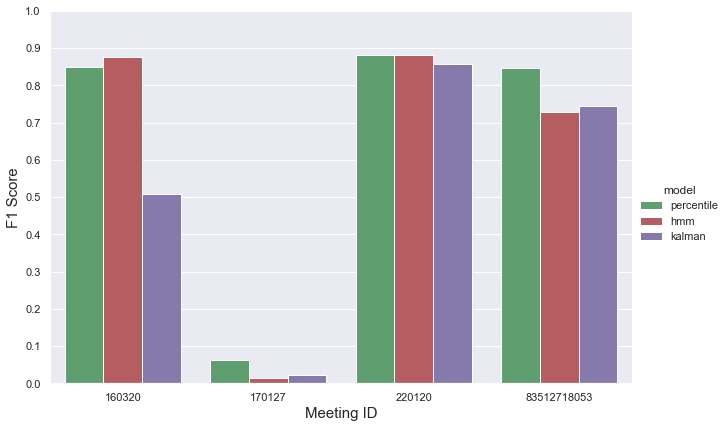

In [27]:
g = sns.catplot(x='meeting_id', y='value', hue='model', data=f1s, kind='bar', height=6, aspect=1.5,palette=sns.color_palette()[2:5])
g.set(yticks=np.arange(0, 1.1, 0.1))
for ax in g.axes.flat:
    ax.set_xlabel("Meeting ID", size=15)
    ax.set_ylabel("F1 Score", size=15)
plt.savefig("thesis/mscs_thesis/figures/3_2_5_pctvskfvshmmf1_unmasked.pdf", dpi=300, bbox_inches='tight')
#g.fig.suptitle('Model F1 Scores by Meeting', y=1.05, fontsize=20);